In [5]:
lst = ['apple', 'rice', 'meat', 'beans']
dd = ' '.join(lst)
print(dd.split())

['apple', 'rice', 'meat', 'beans']


# Supervised Machine Learning
In this notebook, we create a binary classification problem by dividing the citation count at the mean. Papers with citation count less or equal to the mean citation count are labeled as negative (label = 0), whereas those with citation count greater than the mean citation count are labeled as positive (label = 1). 

Topic modeling is implemented on the title and abstract, and we train the following supervised ML models: 

- Logistic Regression

- Support Vector Machine classifier

- Random Forest classifier

- XGBoost classifier

- Light GBM classifier

In [1]:
%matplotlib inline

# ignore deprecated warning
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.decomposition import LatentDirichletAllocation as LDA
import lightgbm as lgb
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

plt.rcParams.update({'font.size': 15})

In [2]:
# import custom classes
%run -i '../src/helper/transfxn.py'
%run -i '../src/helper/imputer.py'
%run -i '../src/helper/ml.py'
%run -i '../src/helper/text_preprocessing.py'

In [3]:
# instantiate the classes
transfxn = TransformationPipeline()
text_tf = TextPreprocessing()
imputer = DataFrameImputer()
model = SupervisedModels()

# Load data

In [4]:
df = pd.read_csv('../data/data_processed.csv', sep = '\t')
print('Data size', df.shape)
cols = ['arXiv_id', 'title', 'abstract', 'authors', 'year']
df[cols].head()

Data size (295174, 20)


,arXiv_id,title,abstract,authors,year
0,704.0006,Bosonic characters of atomic Cooper pairs acro...,We study the two-particle wave function of p...,"['PongY. H.', 'LawC. K.']",2007
1,704.0008,Numerical solution of shock and ramp compressi...,A general formulation was developed to repre...,['SwiftDamian C.'],2007
2,704.0025,Spectroscopic Properties of Polarons in Strong...,We present recent advances in understanding ...,"[""MishchenkoA. S.CREST, Japan Science and Tech...",2007
3,704.0027,Filling-Factor-Dependent Magnetophonon Resonan...,We describe a peculiar fine structure acquir...,"['GoerbigM. O.', 'FuchsJ. -N.', 'KechedzhiK.',...",2007
4,704.003,Tuning correlation effects with electron-phono...,We investigate the effect of tuning the phon...,"['HagueJ. P.', ""d'AmbrumenilN.""]",2007


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 295174 entries, 0 to 295173
Data columns (total 20 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   abstract         295174 non-null  object 
 1   arXiv_id         295174 non-null  object 
 2   authors          295174 non-null  object 
 3   categories       295174 non-null  object 
 4   comments         295173 non-null  object 
 5   date_created     295174 non-null  object 
 6   doi              295174 non-null  object 
 7   title            295174 non-null  object 
 8   num_of_authors   295174 non-null  int64  
 9   year             295174 non-null  int64  
 10  month            295174 non-null  object 
 11  day_of_week      295174 non-null  object 
 12  num_of_pages     196991 non-null  float64
 13  num_of_figures   158440 non-null  float64
 14  length_of_abstr  295174 non-null  int64  
 15  citation_count   295174 non-null  int64  
 16  p_age            295174 non-null  int6

# Descriptive statistics

In [6]:
df.describe()

,num_of_authors,year,num_of_pages,num_of_figures,length_of_abstr,citation_count,p_age,wday_ct,month_ct,year_ct
count,295174.000000,295174.000000,196991.000000,158440.000000,295174.000000,295174.000000,295174.000000,295174.000000,295174.000000,295174.000000
mean,3.889807,2010.527292,12.863730,6.593228,897.299322,24.929008,9.472708,48839.456158,24657.074336,13245.038696
std,2.922733,6.794057,15.897621,14.012105,351.711874,99.294934,6.794057,11700.358312,1191.903409,4308.690391
min,1.000000,1992.000000,0.000000,0.000000,7.000000,0.000000,0.000000,14925.000000,22499.000000,284.000000
25%,2.000000,2005.000000,5.000000,4.000000,639.000000,1.000000,4.000000,47270.000000,23902.000000,10239.000000
50%,3.000000,2012.000000,10.000000,5.000000,843.000000,7.000000,8.000000,54235.000000,24968.000000,14743.000000
75%,5.000000,2016.000000,16.000000,8.000000,1107.000000,23.000000,15.000000,54239.000000,25778.000000,16731.000000
max,141.000000,2020.000000,2008.000000,4989.000000,6091.000000,19719.000000,28.000000,54592.000000,26325.000000,18895.000000


# Class distribution
In order to create a class label for supervised machine learning, we divide the citation count by the mean. Papers with citation count less or equal to the mean are labeled as negative (label = 0), whereas those with citation count greater than the mean are labeled as positive (label = 1)

Text(0, 0.5, 'Count (log scale)')

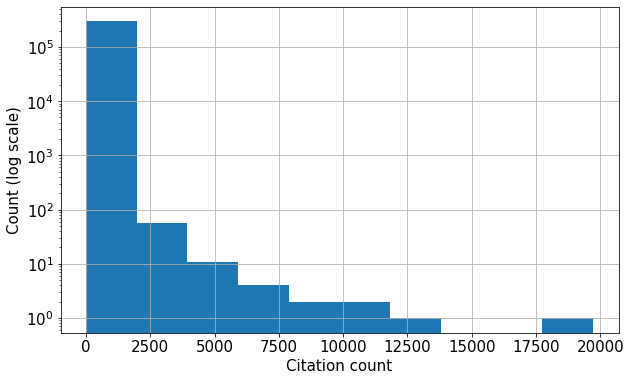

In [7]:
df['citation_count'].hist(log = True, figsize = (10,6))
plt.xlabel('Citation count')
plt.ylabel('Count (log scale)')

In [8]:
df['class'] = np.where(df.citation_count <= df.citation_count.mean(), 0,1)

In [9]:
label_pct = df['class'].value_counts(normalize = True)*100
label_ct =  df['class'].value_counts()
pd.DataFrame({'labels': label_pct.index, 
              'count': label_ct.values, 
              'percentage': label_pct.values
             })

,labels,count,percentage
0,0,225719,76.469811
1,1,69455,23.530189


# Reduce the dataset
We reduce the dataset to speed up training of the models

In [10]:
X1, X2, y1, y2 = train_test_split(df, df['class'], test_size = 0.04, random_state = 42, 
                                  stratify = df['class'])

In [11]:
print('Large subset size:', X1.shape, y1.shape)
print('Small subset size:', X2.shape, y2.shape)

Large subset size: (283367, 21) (283367,)
Small subset size: (11807, 21) (11807,)


In [12]:
# pickle the small subset
X2.to_pickle('../data/model_data.pkl')

In [13]:
# reload the small subset
df_small = pd.read_pickle('../data/model_data.pkl').reset_index(drop = True)

# Topic modeling with LDA

In [14]:
# join the title & abstract
df_small['docs'] = df_small['abstract'] + df_small['title']

In [15]:
# bow vector
X, vocab  = text_tf.bow_vector(df_small, text_col = 'docs')
print('Data size of bow vector:', X.shape)

Data size of bow vector: (11807, 117732)


In [16]:
# LDA with 20 topics
lda = LDA(n_components = 20, learning_method = 'batch', random_state = 42)
lda.fit(X) # fit model
joblib.dump(lda, '../data/lda_model.pkl') # save trained model
print("LDA model size:", lda.components_.shape)

LDA model size: (20, 117732)


In [17]:
topics = ['topic{}'.format(i) for i in range(lda.components_.shape[0])]
components = pd.DataFrame(lda.components_.T, index=vocab, columns = topics)/len(X)
n_top_words = 10
for i, topic_dist in enumerate(topics):
    topic_words = components[topics[i]].sort_values(ascending = False)[:n_top_words].index
    print('Topic {}: {}'.format(i, ' '.join(topic_words)))

Topic 0: energy graphene electron theory dirac distribution system method structure band
Topic 1: method system density state order resonance effect calculation band present
Topic 2: phase model topological system order graphene band transition structure state
Topic 3: model phase transition vortex order lattice scale state critical function
Topic 4: structure charge water density material distribution found defect transport sphere
Topic 5: system model state field energy theory density wave boundary particle
Topic 6: model phase system time state quantum dynamic equilibrium also transport
Topic 7: state phase model entanglement entropy particle theory number equation potential
Topic 8: state magnetic phase spin order transition system model field interaction
Topic 9: temperature transition high energy structure effect theory surface order material
Topic 10: state quantum condensate system interaction atom trap field effect couple
Topic 11: field effect cavity entropy cool large conduc

In [18]:
lda_model = joblib.load('../data/lda_model.pkl') # load trained LDA model
topic_vector = lda_model.transform(X) # extract the topic vector

In [19]:
# create topic vector dataframe
cols = ['topic{}'.format(i) for i in range(lda_model.components_.shape[0])]
df_topic_vec = pd.DataFrame(topic_vector, columns = cols)
df_topic_vec.insert(loc =0, column= 'arXiv_id', value = df_small.arXiv_id)
df_topic_vec.round(2).head()

,arXiv_id,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,...,topic10,topic11,topic12,topic13,topic14,topic15,topic16,topic17,topic18,topic19
0,cond-mat/0406610,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,...,0.14,0.0,0.21,0.00,0.00,0.37,0.0,0.26,0.0,0.0
1,1005.3429,0.0,0.0,0.0,0.0,0.0,0.61,0.0,0.00,0.00,...,0.21,0.0,0.00,0.17,0.00,0.00,0.0,0.00,0.0,0.0
2,2002.07294,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.81,...,0.00,0.0,0.00,0.17,0.00,0.00,0.0,0.00,0.0,0.0
3,cond-mat/9802279,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,...,0.00,0.0,0.24,0.00,0.74,0.00,0.0,0.00,0.0,0.0
4,1107.0743,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.32,0.00,...,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.67,0.0,0.0


# Final dataframe

In [20]:
col_to_drop = ['abstract', 'authors','categories', 'citation_count',
               'date_created', 'doi', 'title', 'comments', 'docs']
df_cnsld = df_small.merge(df_topic_vec, how = 'inner', on = 'arXiv_id')
df_cnsld.drop(col_to_drop, axis=1, inplace=True)
df_cnsld.head()

,arXiv_id,num_of_authors,year,month,day_of_week,num_of_pages,num_of_figures,length_of_abstr,p_age,wday_ct,...,topic10,topic11,topic12,topic13,topic14,topic15,topic16,topic17,topic18,topic19
0,cond-mat/0406610,4,2004,June,Thursday,5.0,4.0,695,16,53004,...,0.138167,0.000893,0.209532,0.000893,0.000893,0.373842,0.000893,0.264173,0.000893,0.000893
1,1005.3429,6,2010,May,Wednesday,5.0,4.0,742,10,54235,...,0.206251,0.000758,0.000758,0.171557,0.000758,0.000758,0.000758,0.000758,0.000758,0.000758
2,2002.07294,3,2020,February,Monday,NaN,NaN,806,0,54239,...,0.000714,0.000714,0.000714,0.172442,0.000714,0.000714,0.000714,0.000714,0.000714,0.000714
3,cond-mat/9802279,1,1998,February,Wednesday,16.0,NaN,327,22,54235,...,0.001429,0.001429,0.236762,0.001429,0.737523,0.001429,0.001429,0.001429,0.001429,0.001429
4,1107.0743,2,2011,July,Monday,13.0,7.0,646,9,54239,...,0.000794,0.000794,0.000794,0.000794,0.000794,0.000794,0.000794,0.670052,0.000794,0.000794


# Prepare the dataset for machine learning

In [21]:
# feature matrix and class label
X, y = df_cnsld.drop(['arXiv_id', 'class'], axis = 1), df_cnsld['class']
print('Data size:', X.shape, y.shape)

Data size: (11807, 31) (11807,)


# Create a test set
We now split the data set into $80\%$ training set and $20\%$ test set in a stratify fashion

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42, stratify = y)

In [23]:
print('Training set size:', X_train.shape, y_train.shape)
print('Test set size:', X_test.shape, y_test.shape)

Training set size: (9445, 31) (9445,)
Test set size: (2362, 31) (2362,)


In [24]:
print('Training set class distribution:\n', (y_train.value_counts()/X_train.shape[0])*100)
print('--' * 15)
print('Test set class distribution:\n', (y_test.value_counts()/X_test.shape[0])*100)

Training set class distribution:
 0    76.474325
1    23.525675
Name: class, dtype: float64
------------------------------
Test set class distribution:
 0    76.460627
1    23.539373
Name: class, dtype: float64


# Transformation pipeline

## 1. Impute missing values

In [25]:
# Fit transform the training set
X_train_imputed = imputer.fit_transform(X_train)

# Only transform the test set
X_test_imputed = imputer.transform(X_test)

## 2. Pre-processing

In [26]:
# transform and scale data
X_train_scaled, X_test_scaled, feat_names = transfxn.preprocessing(X_train_imputed, X_test_imputed)

In [27]:
# print size of the data after pre-processing
print('Training set size after pre-processing:', X_train_scaled.shape)
print('Test set size after pre-processing:', X_test_scaled.shape)

Training set size after pre-processing: (9445, 48)
Test set size after pre-processing: (2362, 48)


In [28]:
# convert the class labels to arrays
y_train, y_test = y_train.values,  y_test.values

# A. Model Selection by Cross-Validation

## A-1. Logistic Regression

In [29]:
log_clf = LogisticRegression(random_state=42)   
model.eval_metrics_cv(log_clf, X_train_scaled, y_train, cv_fold = 10, 
                      scoring = 'accuracy',model_nm = "Logistic Regression")

10-Fold cross-validation results for Logistic Regression
------------------------------------------------------------
Accuracy (std): 0.766860 (0.005756)
AUROC: 0.716384
AUPRC: 0.406872
Predicted classes: [0 1]
Confusion matrix:
 [[7069  154]
 [2048  174]]
Classification report:
               precision    recall  f1-score   support

           0       0.78      0.98      0.87      7223
           1       0.53      0.08      0.14      2222

    accuracy                           0.77      9445
   macro avg       0.65      0.53      0.50      9445
weighted avg       0.72      0.77      0.69      9445

------------------------------------------------------------


## A-1-1.  Hyperparameter tuning - LR
 In this section, we shall optimize the **AUC** of the classifiers using grid/randomized search, cross-validation, and cost sensitive method

In [30]:
# class ratio of the 
# negative class to the positive class
neg = y_train == 0
pos = y_train == 1
class_ratio = np.sum(neg)/np.sum(pos)
class_ratio

3.2506750675067506

In [31]:
# Range of hyperparameters
params = {'C': [2**x for x in range(-2,10,2)],
           'class_weight': ['balanced', None, {0:1, 1:class_ratio}]
            }
                             
# Grid search
log_clf = LogisticRegression()   
gsearch_log = RandomizedSearchCV(estimator = log_clf, param_distributions = params, 
                                scoring = 'roc_auc', cv = 10, n_jobs = -1, 
                                n_iter = 200, random_state = 42, verbose = 1)

# Fit the training set
gsearch_log.fit(X_train_scaled, y_train)

# Pickle trained model
joblib.dump(gsearch_log.best_estimator_, '../data/log_clf.pkl')

# Print results
print('Best AUC score:', gsearch_log.best_score_)
print('Best parameters:', gsearch_log.best_params_)    

Fitting 10 folds for each of 18 candidates, totalling 180 fits
Best AUC score: 0.7165348834432221
Best parameters: {'class_weight': None, 'C': 0.25}


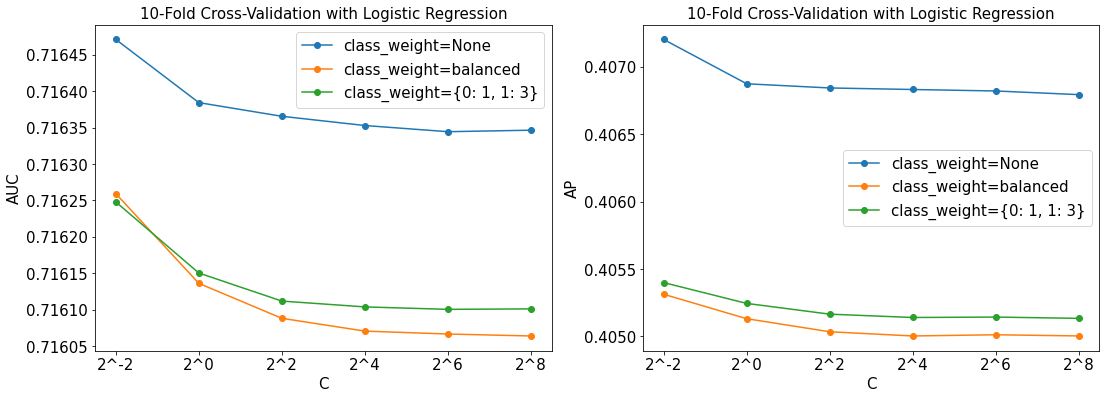

In [32]:
model.plot_auc_ap_lr(X_train_scaled, y_train, cv_fold = 10)

## A-2. Support Vector Machine

In [33]:
svm_clf = SVC(probability = True, kernel = 'rbf', random_state=42)   
model.eval_metrics_cv(svm_clf, X_train_scaled, y_train, cv_fold = 10, scoring = 'accuracy', 
                      model_nm = "SVM Classifier")

10-Fold cross-validation results for SVM Classifier
------------------------------------------------------------
Accuracy (std): 0.765590 (0.001740)
AUROC: 0.670506
AUPRC: 0.390850
Predicted classes: [0 1]
Confusion matrix:
 [[7211   12]
 [2202   20]]
Classification report:
               precision    recall  f1-score   support

           0       0.77      1.00      0.87      7223
           1       0.62      0.01      0.02      2222

    accuracy                           0.77      9445
   macro avg       0.70      0.50      0.44      9445
weighted avg       0.73      0.77      0.67      9445

------------------------------------------------------------


## A-2-1. Hyperparameter tuning- SVM

In [34]:
# Range of hyperparameters
params = {'C': [2**x for x in range(-2,8,2)], 
          'gamma': [2**x for x in range(-11,1,2)],
          'class_weight': ['balanced', None, {0:1, 1:class_ratio}]
         } 
                                                              
# Randomized search for SVM
svm_clf = SVC(probability = True, kernel = 'rbf')
rsearch_svm = RandomizedSearchCV(svm_clf, param_distributions = params, cv = 10,
                                 scoring = 'roc_auc', n_iter =200,
                                 n_jobs = -1,random_state = 42, verbose = 1) 
# Fit the training set
rsearch_svm.fit(X_train_scaled, y_train)

# Pickle trained model
joblib.dump(rsearch_svm.best_estimator_, '../data/svm_clf.pkl')

print('Best AUC score: ', rsearch_svm.best_score_)
print('Best parameters: ', rsearch_svm.best_params_)  

Fitting 10 folds for each of 90 candidates, totalling 900 fits
Best AUC score:  0.7204462530501268
Best parameters:  {'gamma': 0.00048828125, 'class_weight': {0: 1, 1: 3.2506750675067506}, 'C': 64}


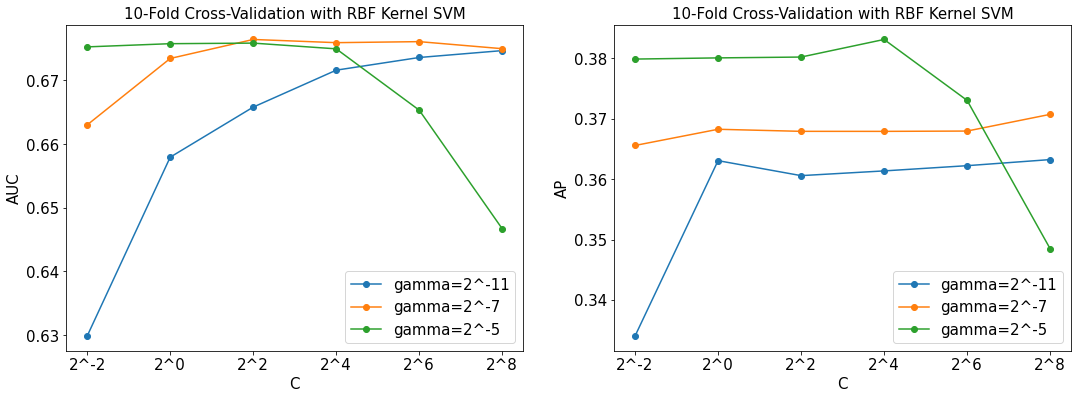

In [35]:
model.plot_auc_ap_svm(X_train_scaled, y_train, cv_fold = 10, class_weight = None)

## A-3. Random Forest

In [36]:
rf_clf = RandomForestClassifier(random_state = 42)                         
model.eval_metrics_cv(rf_clf, X_train_scaled, y_train, cv_fold = 10, 
                      scoring = 'accuracy',  model_nm = "Random Forest Classifier")

10-Fold cross-validation results for Random Forest Classifier
------------------------------------------------------------
Accuracy (std): 0.763050 (0.006305)
AUROC: 0.693526
AUPRC: 0.373784
Predicted classes: [0 1]
Confusion matrix:
 [[6990  233]
 [2005  217]]
Classification report:
               precision    recall  f1-score   support

           0       0.78      0.97      0.86      7223
           1       0.48      0.10      0.16      2222

    accuracy                           0.76      9445
   macro avg       0.63      0.53      0.51      9445
weighted avg       0.71      0.76      0.70      9445

------------------------------------------------------------


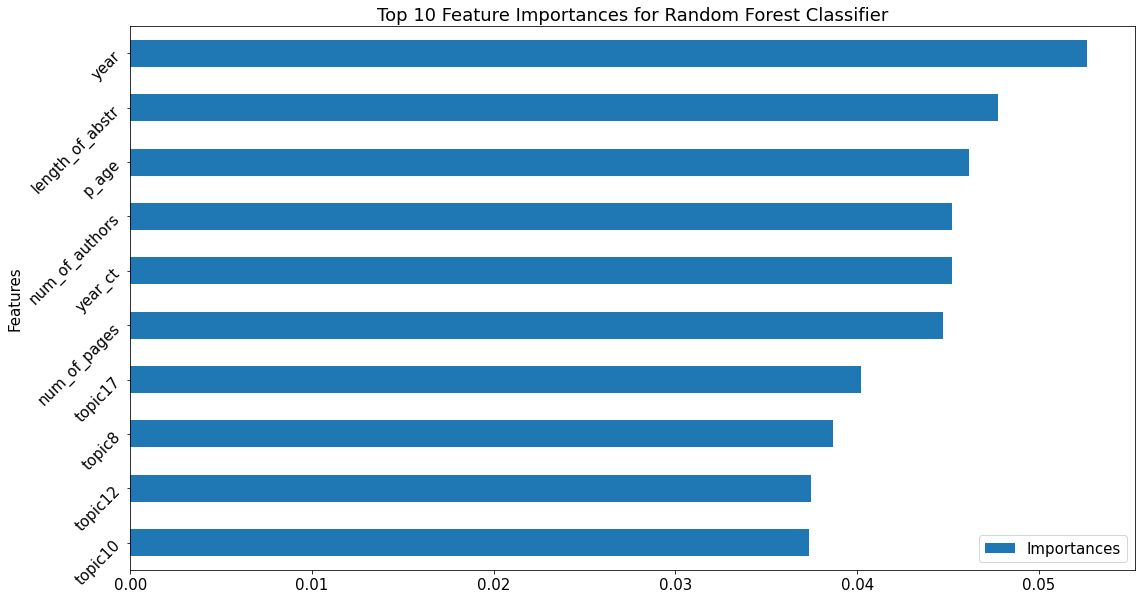

In [37]:
# Compute feature importances
importances_df = pd.DataFrame({'Features': feat_names, 
                                'Importances': rf_clf.feature_importances_
                                })
# Bar plot
importances_df.sort_values('Importances', ascending = True, inplace = True)
importances_df.set_index('Features', inplace = True)
importances_df.tail(10).plot(kind='barh', figsize = (18,10))
plt.yticks(rotation = 45)
plt.title('Top 10 Feature Importances for Random Forest Classifier')
plt.show()

## A-3-1.  Hyperparameter tuning - RF

In [38]:
# Range of hyperparameters
params = {'max_features': [0.5, 1, 'sqrt', 'log2', None],
          'max_depth': range(2,8,1),
          'min_samples_split': range(2,10,1),
          'class_weight': ['balanced', None, {0: 1, 1: class_ratio}]
                         }

# Randomized search
rf_clf = RandomForestClassifier(n_estimators = 1000, random_state = 42)           
rsearch_rf = RandomizedSearchCV(estimator = rf_clf, param_distributions = params, 
                                scoring = 'roc_auc', cv = 10, n_jobs = -1, n_iter = 200, 
                                random_state = 42, verbose = 1)  
# Fit the  training set                                                    
rsearch_rf.fit(X_train_scaled, y_train)

# Pickle trained model
joblib.dump(rsearch_rf.best_estimator_, '../data/rf_clf.pkl')

# Print results
print('Randomized search best AUC score:', rsearch_rf.best_score_) 
print('Randomized search best hyperparameters:', rsearch_rf.best_params_) 

Fitting 10 folds for each of 200 candidates, totalling 2000 fits
Randomized search best AUC score: 0.7240515411470858
Randomized search best hyperparameters: {'min_samples_split': 8, 'max_features': 0.5, 'max_depth': 7, 'class_weight': None}


## A-4. XGBoost

In [39]:
param_dist = {'objective':'binary:logistic', 'eval_metric':'logloss', 
              'learning_rate':0.05, 'random_state':42,'n_jobs':-1,
               'n_estimators':100
              }
              
xgb_clf = xgb.XGBClassifier(**param_dist)
model.eval_metrics_cv(xgb_clf, X_train_scaled, y_train, cv_fold = 10, scoring = 'accuracy',
                      model_nm = "XGBoost Classifier")

10-Fold cross-validation results for XGBoost Classifier
------------------------------------------------------------
Accuracy (std): 0.767919 (0.004893)
AUROC: 0.724294
AUPRC: 0.415983
Predicted classes: [0 1]
Confusion matrix:
 [[7014  209]
 [1983  239]]
Classification report:
               precision    recall  f1-score   support

           0       0.78      0.97      0.86      7223
           1       0.53      0.11      0.18      2222

    accuracy                           0.77      9445
   macro avg       0.66      0.54      0.52      9445
weighted avg       0.72      0.77      0.70      9445

------------------------------------------------------------


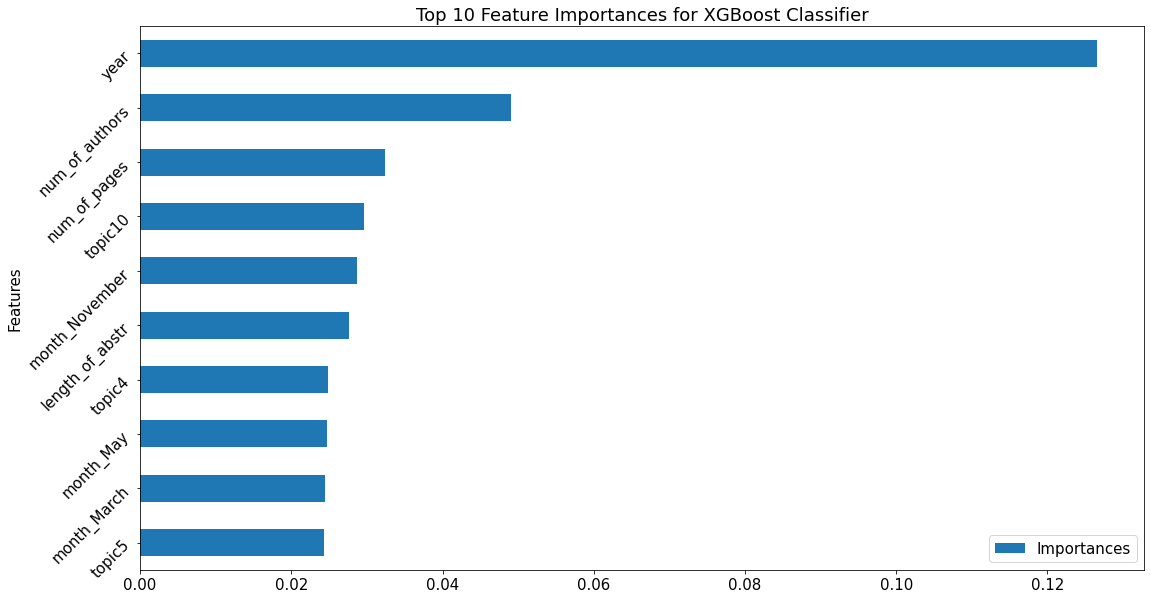

In [40]:
# Compute feature importances
importances_df = pd.DataFrame({'Features': feat_names,
                               'Importances': xgb_clf.feature_importances_
                               })
# Bar plot
importances_df.sort_values('Importances', ascending = True, inplace = True)
importances_df.set_index('Features', inplace = True)
importances_df.tail(10).plot(kind='barh', figsize = (18,10))
plt.yticks(rotation = 45)
plt.title('Top 10 Feature Importances for XGBoost Classifier')
plt.show()

## A-4-1. Hyperparameter tuning  - XGB

In [41]:
# Range of hyperparameters
params = {'max_depth': range(1,10,2), 
          'min_child_weight': range(1,6,2),
          'gamma':[i/100 for i in range(0,6)],
          'subsample':[i/10 for i in range(5,9)],
          'colsample_bytree': [i/10 for i in range(5,9)],
          'learning_rate': [0.01, 0.02, 0.05, 0.1]
          }

# Randomized search
param_dist = {'objective':'binary:logistic', 'eval_metric':'logloss', 'n_estimators':100,
              'scale_pos_weight':class_ratio, 'random_state':42
            }     
xgb_clf = xgb.XGBClassifier(**param_dist)
rsearch_xgb = RandomizedSearchCV(estimator = xgb_clf, param_distributions = params, 
                                  scoring = 'roc_auc', cv = 10, n_jobs = -1, n_iter = 200, 
                                  random_state = 42, verbose = 1)   
# Fit the  training set                                                            
rsearch_xgb.fit(X_train_scaled, y_train)

# Pickle trained model
joblib.dump(rsearch_xgb.best_estimator_, '../data/xgb_clf.pkl')

# Print results
print('Randomized search best AUC score:', rsearch_xgb.best_score_) 
print('Randomized search best hyperparameters:', rsearch_xgb.best_params_) 

Fitting 10 folds for each of 200 candidates, totalling 2000 fits
Randomized search best AUC score: 0.7322449823849444
Randomized search best hyperparameters: {'subsample': 0.8, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0.0, 'colsample_bytree': 0.8}


## 5. LGBM

In [42]:
param_dict = {'boosting_type':'gbdt', 'num_leaves':31, 'max_depth':- 1, 
              'learning_rate':0.05, 'n_estimators':100, 'random_state':42
             }
              
lgb_clf = lgb.LGBMClassifier(**param_dict)
model.eval_metrics_cv(lgb_clf, X_train_scaled, y_train, cv_fold = 10, model_nm = 'LGBM Classifier')

10-Fold cross-validation results for LGBM Classifier
------------------------------------------------------------
Accuracy (std): 0.765483 (0.004864)
AUROC: 0.724098
AUPRC: 0.415440
Predicted classes: [0 1]
Confusion matrix:
 [[6963  260]
 [1955  267]]
Classification report:
               precision    recall  f1-score   support

           0       0.78      0.96      0.86      7223
           1       0.51      0.12      0.19      2222

    accuracy                           0.77      9445
   macro avg       0.64      0.54      0.53      9445
weighted avg       0.72      0.77      0.71      9445

------------------------------------------------------------


Text(0.5, 1.0, 'Top 10 Feature Importances for LGBM Classifier')

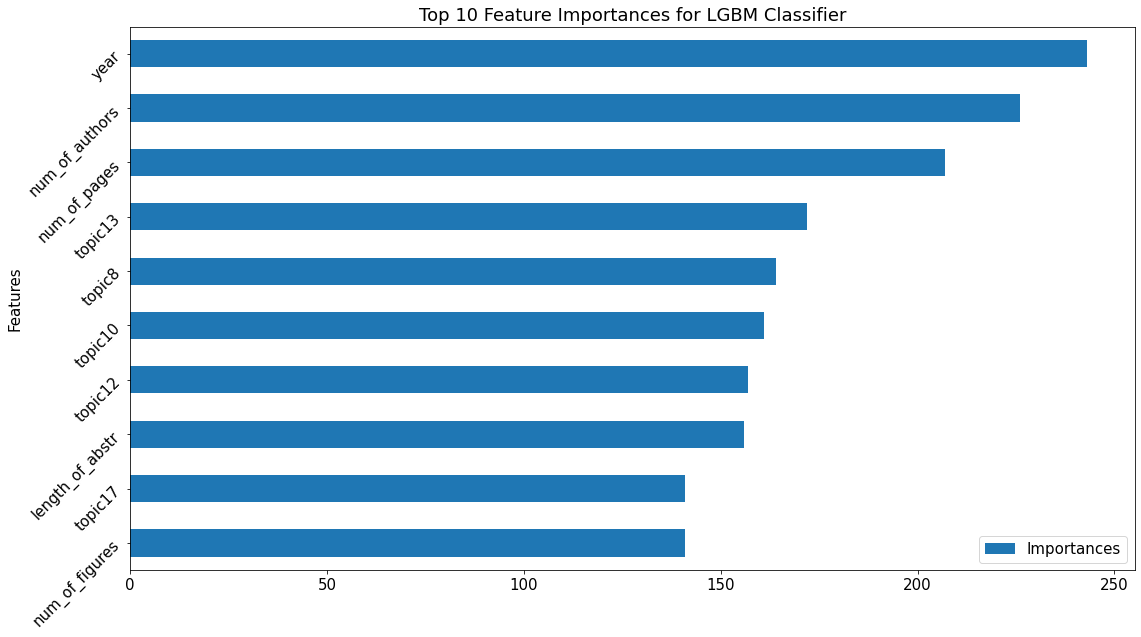

In [43]:
# Compute feature importances
importances_df = pd.DataFrame({'Features': feat_names, 
                               'Importances': lgb_clf.feature_importances_
                              })
# Plot
importances_df.sort_values('Importances', ascending = True, inplace = True)
importances_df.set_index('Features', inplace = True)
importances_df.tail(10).plot(kind='barh', figsize = (18,10))
plt.yticks(rotation = 45)
plt.title('Top 10 Feature Importances for LGBM Classifier')
# plt.savefig('../image/lgbm.png')

## A-5-1. Hyperparameter tuning  - LGBM

In [44]:
# Hyperparameter range
params = {'max_depth': [-1,30,40],
          'num_leaves': range(80,120,10),
          'min_child_samples': range(20,50,10),
          'learning_rate': [0.01, 0.02, 0.05, 0.1]
          }

# Randomized search
param_dict = {'boosting_type':'gbdt', 
              'n_estimators':100, 'random_state':42,
              'scale_pos_weight':class_ratio
             }
             
lgb_clf =  lgb.LGBMClassifier(**param_dict)                       
rsearch_lgbm = RandomizedSearchCV(estimator = lgb_clf, param_distributions = params, 
                                n_iter = 200,scoring = 'roc_auc', cv = 10, 
                                n_jobs = -1, random_state = 42, verbose = 1
                                 )  
# Fit model
rsearch_lgbm.fit(X_train_scaled, y_train)

# Pickle trained model
joblib.dump(rsearch_lgbm.best_estimator_, '../data/lgb_clf.pkl')

# Print results
print('Randomized search best AUC score:', rsearch_lgbm.best_score_) 
print('Best hyperparameters:', rsearch_lgbm.best_params_) 

Fitting 10 folds for each of 144 candidates, totalling 1440 fits
Randomized search best AUC score: 0.7208395090685855
Best hyperparameters: {'num_leaves': 80, 'min_child_samples': 30, 'max_depth': 30, 'learning_rate': 0.02}


In [45]:
# Load trained model
log_clf = joblib.load('../data/log_clf.pkl')
svm_clf = joblib.load('../data/svm_clf.pkl')
rf_clf = joblib.load('../data/rf_clf.pkl')
xgb_clf = joblib.load('../data/xgb_clf.pkl')
lgb_clf = joblib.load('../data/lgb_clf.pkl')

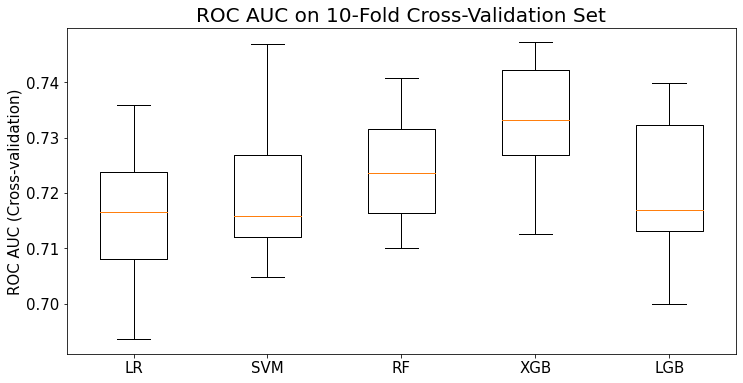

In [47]:
model_dict = {'LR': log_clf, 'SVM': svm_clf, 'RF': rf_clf, 'XGB': xgb_clf, 'LGB': lgb_clf}
roc_scores = []

for i, (name, model_) in enumerate(model_dict.items()):
    score = cross_val_score(model_, X_train_scaled, y_train, cv = 10, scoring = 'roc_auc')
    roc_scores.append(score)

plt.figure(figsize = (12,6))
plt.boxplot(roc_scores)
plt.xticks(np.arange(len(model_dict))+1, list(model_dict.keys()))
plt.title('ROC AUC on 10-Fold Cross-Validation Set', fontsize = 20)
plt.ylabel('ROC AUC (Cross-validation)')
plt.savefig('../images/cv_metric.png')
plt.show()

# C. Prediction on the Test Set 
In this section, we make the final prediction on the test set

## C-1. Logistic Regression

In [48]:
model.test_pred(log_clf, X_test_scaled, y_test, model_nm = "Logistic regression")

Test predictions for Logistic regression
------------------------------------------------------------
Accuracy:  0.768840
AUROC: 0.717179
AUPRC: 0.414357
Predicted classes: [0 1]
Confusion matrix:
 [[1762   44]
 [ 502   54]]
Classification report:
               precision    recall  f1-score   support

           0       0.78      0.98      0.87      1806
           1       0.55      0.10      0.17       556

    accuracy                           0.77      2362
   macro avg       0.66      0.54      0.52      2362
weighted avg       0.72      0.77      0.70      2362

------------------------------------------------------------


## C-2. Support Vector Machine

In [49]:
model.test_pred(svm_clf, X_test_scaled, y_test, model_nm = "SVM classifier")

Test predictions for SVM classifier
------------------------------------------------------------
Accuracy:  0.594412
AUROC: 0.721265
AUPRC: 0.421583
Predicted classes: [0 1]
Confusion matrix:
 [[979 827]
 [131 425]]
Classification report:
               precision    recall  f1-score   support

           0       0.88      0.54      0.67      1806
           1       0.34      0.76      0.47       556

    accuracy                           0.59      2362
   macro avg       0.61      0.65      0.57      2362
weighted avg       0.75      0.59      0.62      2362

------------------------------------------------------------


## C-3. Random Forest

In [50]:
model.test_pred(rf_clf, X_test_scaled, y_test, model_nm = "Random Forest Classifier")

Test predictions for Random Forest Classifier
------------------------------------------------------------
Accuracy:  0.772227
AUROC: 0.735440
AUPRC: 0.443384
Predicted classes: [0 1]
Confusion matrix:
 [[1786   20]
 [ 518   38]]
Classification report:
               precision    recall  f1-score   support

           0       0.78      0.99      0.87      1806
           1       0.66      0.07      0.12       556

    accuracy                           0.77      2362
   macro avg       0.72      0.53      0.50      2362
weighted avg       0.75      0.77      0.69      2362

------------------------------------------------------------


# C-4. XGBoost

In [51]:
model.test_pred(xgb_clf, X_test_scaled, y_test, model_nm = "XGBoost Classifier")

Test predictions for XGBoost Classifier
------------------------------------------------------------
Accuracy:  0.640982
AUROC: 0.730963
AUPRC: 0.444463
Predicted classes: [0 1]
Confusion matrix:
 [[1116  690]
 [ 158  398]]
Classification report:
               precision    recall  f1-score   support

           0       0.88      0.62      0.72      1806
           1       0.37      0.72      0.48       556

    accuracy                           0.64      2362
   macro avg       0.62      0.67      0.60      2362
weighted avg       0.76      0.64      0.67      2362

------------------------------------------------------------


# C-5: Light Gradient Boosting

In [52]:
model.test_pred(lgb_clf, X_test_scaled, y_test, model_nm = "LGBM Classifier")

Test predictions for LGBM Classifier
------------------------------------------------------------
Accuracy:  0.683319
AUROC: 0.723916
AUPRC: 0.434084
Predicted classes: [0 1]
Confusion matrix:
 [[1283  523]
 [ 225  331]]
Classification report:
               precision    recall  f1-score   support

           0       0.85      0.71      0.77      1806
           1       0.39      0.60      0.47       556

    accuracy                           0.68      2362
   macro avg       0.62      0.65      0.62      2362
weighted avg       0.74      0.68      0.70      2362

------------------------------------------------------------


# D. ROC and PR Curves

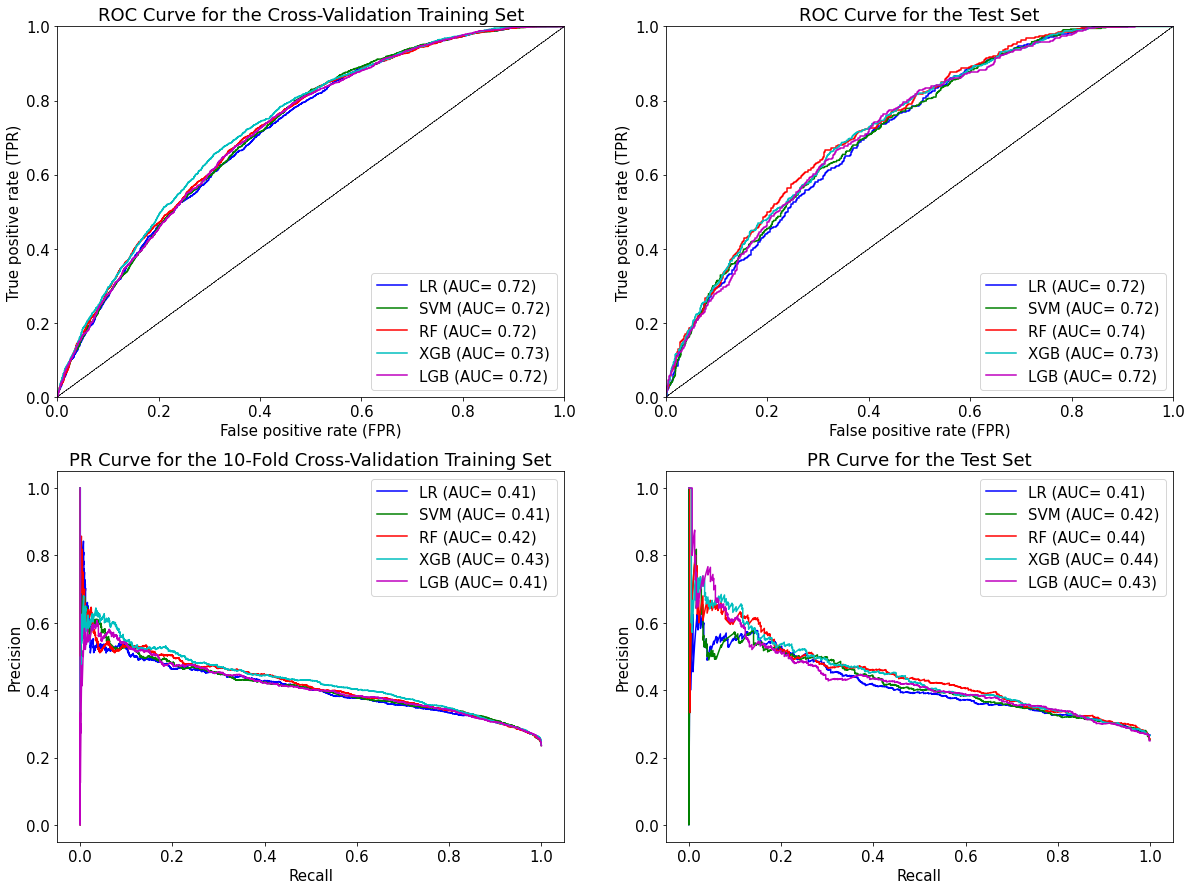

In [53]:
plt.figure(figsize = (20,15))

# LR
model.plot_roc_pr_curves(log_clf, X_train_scaled, y_train, X_test_scaled, y_test, cv_fold = 10,
                       color= 'b', label = 'LR (AUC= %0.2f)')

# SVM
model.plot_roc_pr_curves(svm_clf, X_train_scaled, y_train, X_test_scaled, y_test, cv_fold = 10,
                       color= 'g', label = 'SVM (AUC= %0.2f)')

# RF
model.plot_roc_pr_curves(rf_clf, X_train_scaled, y_train, X_test_scaled, y_test, cv_fold = 10,
                       color= 'r', label = 'RF (AUC= %0.2f)')

# XGB
model.plot_roc_pr_curves(xgb_clf, X_train_scaled, y_train, X_test_scaled, y_test, cv_fold = 10,
                       color= 'c', label = 'XGB (AUC= %0.2f)')

# LGB
model.plot_roc_pr_curves(lgb_clf, X_train_scaled, y_train, X_test_scaled, y_test, cv_fold = 10,
                       color= 'm', label = 'LGB (AUC= %0.2f)')

# E. AUC-ROC and AUC-PR for Cross-Validation vs. Test Sets

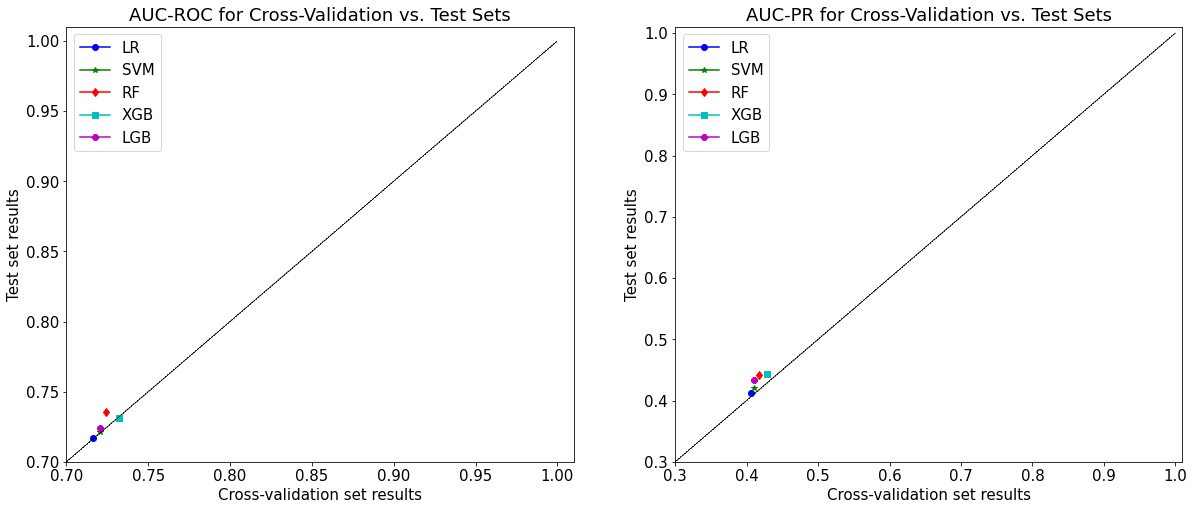

In [54]:
plt.figure(figsize = (20,8))

# LR
model.plot_aucroc_aucpr(log_clf, X_train_scaled, y_train, X_test_scaled, y_test, cv_fold = 10,
                       marker = 'o', color= 'b', label = 'LR')

# SVM
model.plot_aucroc_aucpr(svm_clf, X_train_scaled, y_train, X_test_scaled, y_test, cv_fold = 10,
                       marker = '*', color= 'g', label = 'SVM')
                     
# RF
model.plot_aucroc_aucpr(rf_clf, X_train_scaled, y_train, X_test_scaled, y_test, cv_fold = 10,
                       marker = 'd', color= 'r', label = 'RF')

# XGB
model.plot_aucroc_aucpr(xgb_clf, X_train_scaled, y_train, X_test_scaled, y_test, cv_fold = 10,
                       marker = 's', color= 'c', label = 'XGB')

# LGB
model.plot_aucroc_aucpr(lgb_clf, X_train_scaled, y_train, X_test_scaled, y_test, cv_fold = 10,
                       marker = '8', color= 'm', label = 'LGB')